# 基于 Mindspore 框架的全连接网络梯度下降法

### 1. 导入模块

In [1]:
import mindspore
from mindspore import nn
from mindspore import ops
from mindspore.dataset import vision, transforms
import os
import numpy as np
import moxing as mox
import mindspore.dataset as ds
from mindspore import ParameterTuple
from collections.abc import Iterable
from mindspore import context, DatasetHelper, save_checkpoint


INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


### 2. 定义超参数

In [2]:
BATCH_SIZE = 64
EPOCH = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9
NUM_CLASS = 10

### 3. 加载数据集

In [3]:
datasets_dir = '../datasets'
if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir)
    
if not os.path.exists(os.path.join(datasets_dir, 'MNIST_Data.zip')):
    mox.file.copy('obs://modelarts-labs-bj4-v2/course/hwc_edu/python_module_framework/datasets/mindspore_data/MNIST_Data.zip', 
                  os.path.join(datasets_dir, 'MNIST_Data.zip'))
    os.system('cd %s; unzip MNIST_Data.zip' % (datasets_dir))
    
# 读取完整训练样本和测试样本
mnist_ds_train = ds.MnistDataset(os.path.join(datasets_dir, "MNIST_Data/train"))
mnist_ds_test = ds.MnistDataset(os.path.join(datasets_dir, "MNIST_Data/test"))
train_len = mnist_ds_train.get_dataset_size()
test_len = mnist_ds_test.get_dataset_size()
print("Train dataset:{}, Test dataset:{}".format(train_len, test_len))

Train dataset:60000, Test dataset:10000


### 4. 数据预处理

In [4]:
def datapipe(dataset, batch_size):
    image_transforms = [
        vision.c_transforms.Rescale(1.0 / 255.0, 0),
        vision.c_transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.c_transforms.HWC2CHW()
    ]
    label_transform = transforms.c_transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset


In [5]:
train_dataset = datapipe(mnist_ds_train, BATCH_SIZE)
test_dataset = datapipe(mnist_ds_test, BATCH_SIZE)

In [6]:

for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break



Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


### 5. 定义全连接网络

In [7]:
# Define model
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fully_connected = nn.SequentialCell(
            nn.Dense(28*28, 256),
            nn.ReLU(),
            nn.Dense(256, 128),
            nn.ReLU(),
            nn.Dense(128, NUM_CLASS)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.fully_connected(x)
        return logits

net = Network()
print(net)


Network<
  (flatten): Flatten<>
  (fully_connected): SequentialCell<
    (0): Dense<input_channels=784, output_channels=256, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=256, output_channels=128, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=128, output_channels=10, has_bias=True>
    >
  >


### 6. 定义正向传播、反向传播和参数更新

In [8]:
'''Reference: https://www.mindspore.cn/tutorials/experts/en/r1.7/others/gradient_accumulation.html'''

_sum_op = ops.MultitypeFuncGraph("grad_sum_op")
_clear_op = ops.MultitypeFuncGraph("clear_op")


@_sum_op.register("Tensor", "Tensor")
def _cumulative_grad(grad_sum, grad):
    """Apply grad sum to cumulative gradient."""
    add = ops.AssignAdd()
    return add(grad_sum, grad)


@_clear_op.register("Tensor", "Tensor")
def _clear_grad_sum(grad_sum, zero):
    """Apply zero to clear grad_sum."""
    success = True
    success = ops.depend(success, ops.assign(grad_sum, zero))
    return success


class TrainForwardBackward(nn.Cell):
    def __init__(self, network, optimizer, grad_sum, sens=1.0):
        super(TrainForwardBackward, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()
        self.network.add_flags(defer_inline=True)
        self.weights = ParameterTuple(network.trainable_params())
        self.optimizer = optimizer
        self.grad_sum = grad_sum
        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens
        self.hyper_map = ops.HyperMap()

    def construct(self, *inputs):
        weights = self.weights
        loss = self.network(*inputs)
        sens = ops.Fill()(ops.DType()(loss), ops.Shape()(loss), self.sens)
        grads = self.grad(self.network, weights)(*inputs, sens)
        return ops.depend(loss, self.hyper_map(ops.partial(_sum_op), self.grad_sum, grads))


class TrainOptim(nn.Cell):
    def __init__(self, optimizer, grad_sum):
        super(TrainOptim, self).__init__(auto_prefix=False)
        self.optimizer = optimizer
        self.grad_sum = grad_sum

    def construct(self):
        return self.optimizer(self.grad_sum)


class TrainClear(nn.Cell):
    def __init__(self, grad_sum, zeros):
        super(TrainClear, self).__init__(auto_prefix=False)
        self.grad_sum = grad_sum
        self.zeros = zeros
        self.hyper_map = ops.HyperMap()

    def construct(self):
        success = self.hyper_map(ops.partial(_clear_op), self.grad_sum, self.zeros)
        return success


In [9]:
class GradientAccumulation:
    def __init__(self, network, loss_fn, optimizer):
        self._network = network
        self._loss_fn = loss_fn
        self._optimizer = optimizer

        params = self._optimizer.parameters
        self._grad_sum = params.clone(prefix="grad_sum", init='zeros')
        self._zeros = params.clone(prefix="zeros", init='zeros')
        self._train_forward_backward = self._build_train_forward_backward_network()
        self._train_optim = self._build_train_optim()
        self._train_clear = self._build_train_clear()

    @staticmethod
    def _transform_callbacks(callbacks):
        """Transform callback to a list."""
        if callbacks is None:
            return []

        if isinstance(callbacks, Iterable):
            return list(callbacks)

        return [callbacks]

    def _build_train_forward_backward_network(self):
        """Build forward and backward network"""
        network = self._network
        network = nn.WithLossCell(network, self._loss_fn)
        loss_scale = 1.0
        network = TrainForwardBackward(network, self._optimizer, self._grad_sum, loss_scale).set_train()
        return network

    def _build_train_optim(self):
        """Build optimizer network"""
        network = TrainOptim(self._optimizer, self._grad_sum).set_train()
        return network

    def _build_train_clear(self):
        """Build clear network"""
        network = TrainClear(self._grad_sum, self._zeros).set_train()
        return network

    def train_process(self, epoch, train_dataset, test_dataset):
        """
        Training process. The data would be passed to network directly.
        """
        train_helper = DatasetHelper(train_dataset, dataset_sink_mode=False, epoch_num=epoch)
        test_helper = DatasetHelper(test_dataset, dataset_sink_mode=False, epoch_num=epoch)

        self.loss_ls = []
        self.train_acc = []
        self.test_acc = []
    
        for i in range(epoch):
            sum_loss = 0.0
            correct_train = 0
            for k, next_element in enumerate(train_helper):
                image, label = next_element
                output = self._network(image)
                pred = ops.Argmax(output_type=mindspore.int32)(output)
                correct_train += (pred==label).asnumpy().sum().item()
                loss = self._train_forward_backward(*next_element)
                sum_loss += loss
                self._train_optim()
                self._train_clear()
                
            correct_test = 0
            for k, next_element in enumerate(test_helper):
                image, label = next_element
                output = self._network(image)
                pred = ops.Argmax(output_type=mindspore.int32)(output)
                correct_test += (pred==label).asnumpy().sum().item()
                
            current_loss = float(sum_loss)/train_len
            current_train_acc = float(correct_train)/train_len
            current_test_acc = float(correct_test)/test_len
            self.loss_ls.append(current_loss)
            self.train_acc.append(current_train_acc)
            self.test_acc.append(current_test_acc)
            print("epoch:{}, ".format(i),end="")
            print("train acc:{:.4f}, ".format(current_train_acc),end="")
            print("loss:{:.4f}, ".format(current_loss),end="")
            print("test acc:{:.4f}".format(current_test_acc))
            train_dataset.reset()

        save_checkpoint(self._train_forward_backward, "gradient_accumulation.ckpt", )

    def get_result(self):
        return self.loss_ls, self.train_acc, self.test_acc


### 7. 模型训练

In [12]:
context.set_context(mode=context.GRAPH_MODE, device_target='CPU')
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = [nn.Momentum, nn.SGD, nn.RMSProp, nn.Adam]
name_opt = [" Momentum "," SGD "," RMSProp "," Adam "]
loss_ls, train_acc, test_acc = [], [], []

for i in range(len(name_opt)):
    network = Network()
    if i == 0:
        opt = net_opt[i](network.trainable_params(), LEARNING_RATE, MOMENTUM)
    else:
        opt = net_opt[i](network.trainable_params(), LEARNING_RATE)
    model = GradientAccumulation(network, net_loss, opt)
    print(name_opt[i].center(55,"="))
    model.train_process(EPOCH, train_dataset, test_dataset)
    tmp_loss_ls, tmp_train_acc, tmp_test_acc = model.get_result()
    loss_ls.append(tmp_loss_ls)
    train_acc.append(tmp_train_acc)
    test_acc.append(tmp_test_acc)
    print("\n")

======================= Momentum ======================
epoch:0, train acc:0.8139, loss:0.0090, test acc:0.9431
epoch:1, train acc:0.9612, loss:0.0020, test acc:0.9633
epoch:2, train acc:0.9744, loss:0.0013, test acc:0.9750
epoch:3, train acc:0.9817, loss:0.0009, test acc:0.9747
epoch:4, train acc:0.9859, loss:0.0007, test acc:0.9765
epoch:5, train acc:0.9893, loss:0.0005, test acc:0.9812
epoch:6, train acc:0.9923, loss:0.0004, test acc:0.9806
epoch:7, train acc:0.9940, loss:0.0003, test acc:0.9794
epoch:8, train acc:0.9960, loss:0.0002, test acc:0.9775
epoch:9, train acc:0.9970, loss:0.0002, test acc:0.9822


========================= SGD =========================
epoch:0, train acc:0.2579, loss:0.0336, test acc:0.5728
epoch:1, train acc:0.7755, loss:0.0115, test acc:0.8575
epoch:2, train acc:0.8817, loss:0.0064, test acc:0.8934
epoch:3, train acc:0.9037, loss:0.0052, test acc:0.9106
epoch:4, train acc:0.9177, loss:0.0045, test acc:0.9256
epoch:5, train acc:0.9285, loss:0.0039, test a

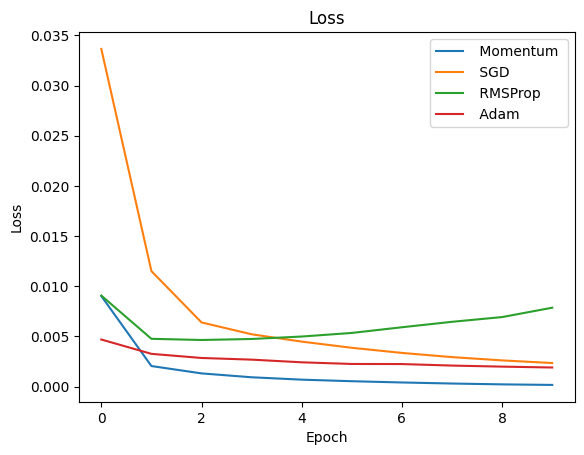

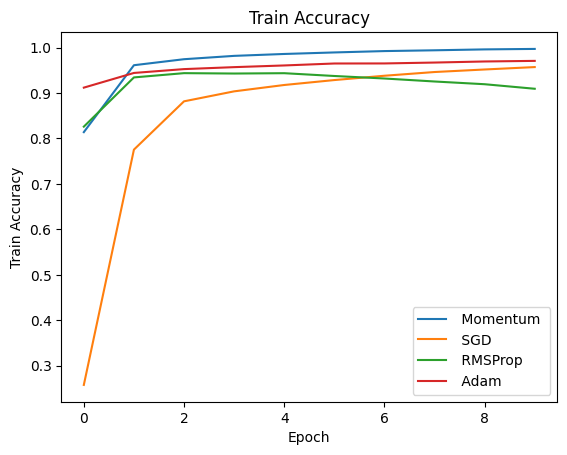

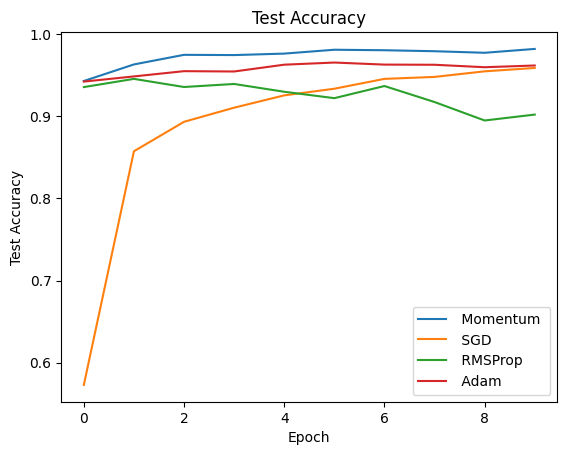

In [24]:
import matplotlib.pyplot as plt
criteria = ["Loss","Train Accuracy","Test Accuracy"]
criteria_ls = [loss_ls, train_acc, test_acc]
for k in range(len(criteria)):
    for i in range(len(name_opt)):
        plt.plot(list(range(0,10)), criteria_ls[k][i], label=name_opt[i])
    plt.xlabel('Epoch')
    plt.ylabel(criteria[k])
    plt.legend()
    plt.title(criteria[k])
    plt.show()
